# Non-learning Approach

In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Open the Sentinel-2 file
with rasterio.open("Sentinel2_LakeGeneva_RGB.tif") as src:
    print(f"Number of bands: {src.count}")
    for i in range(1, src.count + 1):
        print(f"Band {i}: {src.descriptions[i-1]}")

Number of bands: 4
Band 1: B8A
Band 2: B2
Band 3: B3
Band 4: B4


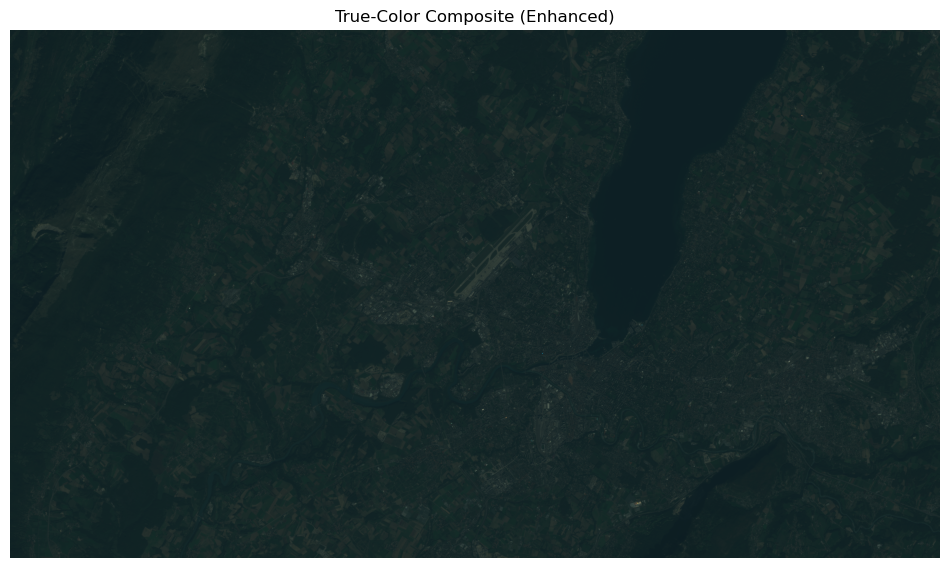

In [2]:
# Open the Sentinel-2 file
with rasterio.open("Sentinel2_LakeGeneva_RGB.tif") as src:
    # Read the RGB bands
    red = src.read(4)  # Band 4: Red
    green = src.read(3)  # Band 3: Green
    blue = src.read(2)  # Band 2: Blue
    green_meta = src.meta  # Save metadata for output

# Normalize band values between 0 and 1
def normalize_band(band):
    return (band - band.min()) / (band.max() - band.min())

red_norm = normalize_band(red)
green_norm = normalize_band(green)
blue_norm = normalize_band(blue)

# Stack the normalized bands to create an RGB composite
rgb_image = np.dstack((red_norm, green_norm, blue_norm))

# Apply gamma correction for brightness adjustment
def apply_gamma(rgb_image, gamma=1.4):
    return np.power(rgb_image, 1/gamma)

rgb_image_gamma = apply_gamma(rgb_image)

# Plot the RGB image
plt.figure(figsize=(12, 8))
plt.imshow(rgb_image_gamma)
plt.title("True-Color Composite (Enhanced)")
plt.axis("off")
plt.show()

In [3]:
# Open the file and extract Green (B03) and NIR (B08)
with rasterio.open("Sentinel2_LakeGeneva_RGB.tif") as src:
    nir = src.read(1)    # NIR band (B08)
    
nir_norm = normalize_band(nir)

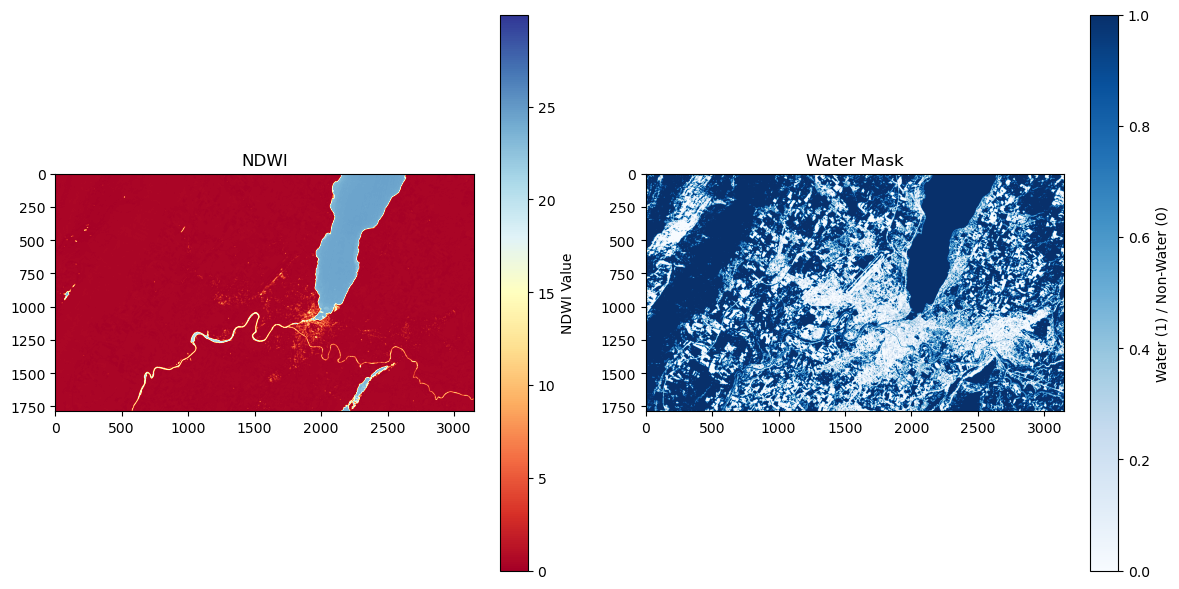

In [4]:
# Calculate NDWI
ndwi = (nir - green) / (nir + green)

# Apply threshold to classify water (e.g., NDWI > 0.3)
threshold = 0.3
water_mask = ndwi >= threshold

# Save the water mask as a GeoTIFF
water_mask_meta = green_meta.copy()
water_mask_meta.update(dtype=rasterio.uint8, count=1)

with rasterio.open("Water_Mask.tif", "w", **water_mask_meta) as dst:
    dst.write(water_mask.astype(rasterio.uint8), 1)

# Plot NDWI and Water Mask
plt.figure(figsize=(12, 6))

# NDWI Visualization
plt.subplot(1, 2, 1)
plt.title("NDWI")
plt.imshow(ndwi, cmap="RdYlBu")
plt.colorbar(label="NDWI Value")

# Water Mask Visualization
plt.subplot(1, 2, 2)
plt.title("Water Mask")
plt.imshow(water_mask, cmap="Blues")
plt.colorbar(label="Water (1) / Non-Water (0)")

plt.tight_layout()
plt.show()

# Deep Learning Approach

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D

# Build the convolutional autoencoder for water detection
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2), padding='same'),

    # Decoder
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    UpSampling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    UpSampling2D((2, 2)),
    Conv2D(1, (3, 3), activation='sigmoid', padding='same')  # Single channel for binary mask
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 1)    │           577 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 297,601 (1.14 MB)

 Trainable params: 297,601 (1.14 MB)

 Non-trainable params: 0 (0.00 B)